In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss
import os
import torchvision
from torchvision.io.image import ImageReadMode
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from torch.utils.data import TensorDataset, DataLoader
import tqdm

In [1]:
class SelfAttention(nn.Module):
    def __init__(self, channels) -> None:
        super().__init__()
        self.channels = channels
        self.query:nn.Conv2d = nn.Conv2d(channels, channels, 1)
        self.key:nn.Conv2d = nn.Conv2d(channels, channels, 1)
        self.value:nn.Conv2d = nn.Conv2d(channels, channels, 1)
        self.gamma:nn.Parameter = nn.Parameter(torch.zeros(1))
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        q:torch.Tensor = self.query(x).view(B, C, H * W).permute(0, 2, 1)
        k:torch.Tensor = self.key(x).view(B, C, H * W)
        v:torch.Tensor = self.value(x).view(B, C, H * W)
        
        attn:torch.Tensor = torch.bmm(q, k) / (C ** 0.5)
        attn = F.softmax(attn, dim=-1)
        out:torch.Tensor = torch.bmm(v, attn.permute(0, 2, 1)).view(B, C, H, W)
        
        return self.gamma * out + x

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.norm1:nn.GroupNorm = nn.GroupNorm(min(32, in_channels), in_channels)
        self.conv1:nn.Conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm2:nn.GroupNorm = nn.GroupNorm(min(32, out_channels), out_channels)
        self.conv2:nn.Conv2d = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.time_mlp:nn.Linear = nn.Linear(time_emb_dim, out_channels)
        self.residual:nn.Conv2d = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
    
    def forward(self, x:torch.Tensor, t:torch.Tensor) -> torch.Tensor:
        h:torch.Tensor = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        h = self.norm2(h)
        h = F.silu(h)
        h += self.time_mlp(t)[:, :, None, None]
        h = self.conv2(h)
        return h + self.residual(x)

class UNet(nn.Module):
    def __init__(self, in_channels:int=3, base_channels:int=64, time_emb_dim:int=128, device:str="cpu") -> None:
        super().__init__()
        self.in_channels:int = in_channels
        self.base_channels:int = base_channels
        self.time_emb_dim:int = time_emb_dim
        self.device:str = device
        
        self.time_mlp:nn.Sequential = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        
        self.encoder:nn.ModuleList = nn.ModuleList([
            ResBlock(in_channels, base_channels, time_emb_dim), # 3 -> 64
            ResBlock(base_channels, base_channels * 2, time_emb_dim), # 64 -> 128
            SelfAttention(base_channels * 2),
            ResBlock(base_channels * 2, base_channels * 4, time_emb_dim), # 128 -> 256
            SelfAttention(base_channels * 4)
        ])
        
        self.middle:ResBlock = ResBlock(base_channels * 4, base_channels * 4, time_emb_dim) # 256 -> 256
        
        self.decoder:nn.ModuleList = nn.ModuleList([
            ResBlock(base_channels * 4 + base_channels * 4, base_channels * 2, time_emb_dim),  # 512 -> 128
            SelfAttention(base_channels * 2),
            ResBlock(base_channels * 2 + base_channels * 2, base_channels, time_emb_dim),  # 256 -> 64
            SelfAttention(base_channels),
            ResBlock(base_channels + base_channels, in_channels, time_emb_dim)  # 128 -> 3
        ])

    def _get_timestep_embedding(self, t:torch.Tensor) -> torch.Tensor:
        """
        Convert a tensor of timesteps t of shape (batch_size, 1) into sinusoidal embeddings of shape (batch_size, time_emb_dim)
        """
        half_dim = self.time_emb_dim // 2
        emb = torch.log(torch.tensor(10000.0, device=self.device)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=self.device, dtype=torch.float32) * -emb)
        emb = t.float() * emb
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], -1)
        return emb
        
    def forward(self, x:torch.Tensor, t:torch.Tensor) -> torch.Tensor:
        t_emb:torch.Tensor = self._get_timestep_embedding(t)
        t_emb = self.time_mlp(t_emb)
        
        skips:list[torch.Tensor] = list[torch.Tensor]()
        for layer in self.encoder:
            x = layer(x, t_emb) if isinstance(layer, ResBlock) else layer(x)
            skips.append(x)

        # print([skip.shape for skip in skips])

        x = self.middle(x, t_emb)
        
        for layer in self.decoder:
            skip = skips.pop()
            if isinstance(layer, ResBlock):
                x = torch.cat([x, skip], dim=1)
                x = layer(x, t_emb)
            else:
                x = layer(x)
        
        return x

NameError: name 'nn' is not defined

In [ ]:
class DiffusionModel:
    def __init__(self, model:UNet, optimizer:torch.optim.Optimizer, criterion:_Loss,timesteps:int=1000, device:str="cpu") -> None:
        self.model:UNet = model.to(device)
        self.optimizer:torch.optim.Optimizer = optimizer
        self.criterion:_Loss = criterion
        self.timesteps:int = timesteps
        self.device:str = device
        self.beta_schedule:torch.Tensor = torch.linspace(1e-4, 0.02, timesteps)
        self.alpha:torch.Tensor = 1.0 - self.beta_schedule
        self.alpha_bar:torch.Tensor = torch.cumprod(self.alpha, dim=0)
    
    #x0.shape : (batch_size, in_channels, base_channels, base_channels)
    #t.shape : (batch_size)
    def add_noise(self, x0:torch.Tensor, t:torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        noise:torch.Tensor = torch.randn(x0.shape)
        alpha_bar_t:torch.Tensor = self.alpha_bar[t].view(-1, 1, 1, 1)
        return (torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise).to(self.device), noise.to(self.device)
    
    def train_step(self, x0:torch.Tensor, perform_SGD:bool = True) -> tuple[float, torch.Tensor]:
        batch_size:int = x0.shape[0]
        t:torch.Tensor = torch.randint(0, self.timesteps, (batch_size,))
        xt, noise = self.add_noise(x0, t)
        t= t.float().unsqueeze(1).to(self.device)
        self.optimizer.zero_grad()
        pred_noise:torch.Tensor = self.model(xt, t)
        loss:torch.Tensor = self.criterion(pred_noise, noise)
        if perform_SGD:
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            self.optimizer.step()
        return loss.item(), pred_noise
    
    def sample(self, nb_sample:int) -> torch.Tensor:
        size:tuple[int] = (nb_sample, self.model.base_channels, self.model.base_channels, self.model.base_channels)
        x:torch.Tensor = torch.randn(size).to(self.device)
        for t in reversed(range(0, self.timesteps)):
            t_tensor:torch.Tensor = torch.tensor([t], device=self.device).float().unsqueeze(1)
            pred_noise:torch.Tensor = self.model(x, t_tensor)
            alpha_t:float = self.alpha[t]
            alpha_bar_t:float = self.alpha_bar[t]
            beta_t:float = self.beta_schedule[t]
            noise:torch.Tensor = None
            if t > 0:
                noise = torch.randn(x.shape, device=self.device)
            else:
                noise = torch.zeros(x.shape, device=self.device)
            x = 1 / torch.sqrt(alpha_t) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * pred_noise) + torch.sqrt(beta_t) * noise

        return torch.clamp(x, 0.0, 1.0)

In [ ]:
def load_dataset() -> list[torch.Tensor]:
    images_dir:str = os.path.join(os.getcwd(), "Dataset", "64x64")
    images_path:list[str] = os.listdir(images_dir)
    images:list[torch.Tensor] = list[torch.Tensor]()

    for image_local_path in images_path:
        image_absolute_path:str = os.path.join(images_dir, image_local_path)
        image:torch.Tensor = torchvision.io.read_image(image_absolute_path, ImageReadMode.RGB).type(torch.float32) / 255.0
        images.append(image)

    return images

dataset:list[torch.Tensor] = load_dataset()

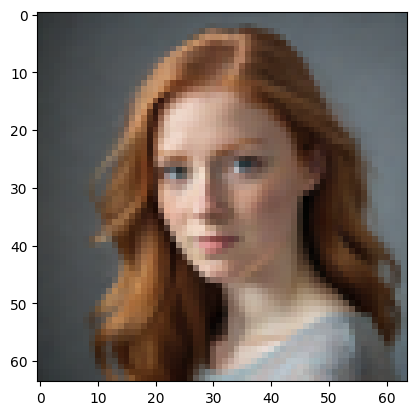

In [ ]:
def plot_dataset_image(nb_image:int) -> None:
    for _ in range(0, nb_image):
        index:int = random.randint(0, len(dataset) - 1)
        image:torch.Tensor = dataset[index]
        image = image.permute(1, 2, 0)
        plt.imshow(image)
        plt.show()
        
plot_dataset_image(1)

In [ ]:
def test_add_noise() -> None:
    unet:UNet = UNet(3, 64, 128)
    diffusion:DiffusionModel = DiffusionModel(unet, 1000, "cpu")
    input:torch.Tensor = dataset[0].unsqueeze(0)
    t:torch.Tensor = torch.tensor(10)
    xt, noise = diffusion.add_noise(input, t)
    xt = xt.squeeze(0).permute(1, 2, 0)
    noise = noise.squeeze(0).permute(1, 2, 0)
    plt.imshow(input.squeeze(0).permute(1, 2, 0))
    plt.show()
    plt.imshow(xt)
    plt.show()
    plt.imshow(noise)
    plt.show()
    
# test_add_noise()

In [ ]:
def add_regular_noise(images:torch.Tensor, min_noise_delta:float, max_noise_delta:float, noise_variant_per_epoch:int, device:str = "cpu") -> tuple[torch.Tensor, torch.Tensor]:
    batch_size = images.shape[0]
    new_images_lst:list[torch.Tensor] = list[torch.Tensor]()
    for i in range(0, batch_size):
        for _ in range(0, noise_variant_per_epoch):
            new_images_lst.append(images[i])
    new_images:torch.Tensor = torch.stack(new_images_lst).cpu()

    size:tuple[int] = (images.shape[0] * noise_variant_per_epoch, images.shape[1], images.shape[2], images.shape[3])
    noise:torch.Tensor = torch.rand(size)
    noise_deltas:torch.Tensor = (max_noise_delta - min_noise_delta) * torch.rand(batch_size * noise_variant_per_epoch) + min_noise_delta
    noise_levels:torch.Tensor = (torch.rand(batch_size * noise_variant_per_epoch) * (1.0 - noise_deltas)) + (noise_deltas * 0.5)

    min_noise_levels = noise_levels - (noise_deltas * 0.5)
    max_noise_levels = noise_levels + (noise_deltas * 0.5)

    min_noisy_images = (new_images * (1.0 - min_noise_levels.view(-1, 1, 1, 1))) + (noise * min_noise_levels.view(-1, 1, 1, 1))
    max_noisy_images = (new_images * (1.0 - max_noise_levels.view(-1, 1, 1, 1))) + (noise * max_noise_levels.view(-1, 1, 1, 1))

    return (min_noisy_images.to(device), max_noisy_images.to(device))

In [ ]:
def add_gaussian_noise(images:torch.Tensor, min_noise_delta:float, max_noise_delta:float, noise_variant_per_epoch:int, device:str = "cpu") -> tuple[torch.Tensor, torch.Tensor]:
    batch_size = images.shape[0]
    new_images_lst:list[torch.Tensor] = list[torch.Tensor]()
    for i in range(0, batch_size):
        for _ in range(0, noise_variant_per_epoch):
            new_images_lst.append(images[i])
    new_images:torch.Tensor = torch.stack(new_images_lst).cpu()

    size:tuple[int] = (images.shape[0] * noise_variant_per_epoch, images.shape[1], images.shape[2], images.shape[3])
    noise:torch.Tensor = torch.clamp(torch.normal(torch.ones(size) * 0.5, torch.ones(size) * 0.125), torch.zeros(size), torch.ones(size))
    noise_deltas:torch.Tensor = (max_noise_delta - min_noise_delta) * torch.rand(batch_size * noise_variant_per_epoch) + min_noise_delta
    noise_levels:torch.Tensor = (torch.rand(batch_size * noise_variant_per_epoch) * (1.0 - noise_deltas)) + (noise_deltas * 0.5)

    min_noise_levels = noise_levels - (noise_deltas * 0.5)
    max_noise_levels = noise_levels + (noise_deltas * 0.5)

    min_noisy_images = (new_images * (1.0 - min_noise_levels.view(-1, 1, 1, 1))) + (noise * min_noise_levels.view(-1, 1, 1, 1))
    max_noisy_images = (new_images * (1.0 - max_noise_levels.view(-1, 1, 1, 1))) + (noise * max_noise_levels.view(-1, 1, 1, 1))

    return (min_noisy_images.to(device), max_noisy_images.to(device))

In [ ]:
def plot_noisy_images(nb_image:int) -> None:
    images:torch.Tensor = torch.stack([dataset[random.randint(0, len(dataset))] for _ in range(0, nb_image)])
    nb_variants:int = 1
    noisy_images:tuple[torch.Tensor, torch.Tensor] = add_gaussian_noise(images, 0.025, 0.05, nb_variants, "cpu")

    for i in range(0, nb_image):
        plt.imshow(images[i].permute(1, 2, 0))
        plt.show()
        for j in range(0, nb_variants):
            plt.imshow(noisy_images[0][i * nb_variants + j].permute(1, 2, 0))
            plt.show()
            plt.imshow(noisy_images[1][i * nb_variants + j].permute(1, 2, 0))
            plt.show()

# plot_noisy_images(1)

In [ ]:
#training params
lr:float = 0.0001
batch_size:int = 32
timestep:int = 1000
time_embedding_dim:int = 128
epochs:int = 50
test_proportion:float = 0.1
saving_model:bool = True
print_epoch_interval:int = -1
nb_sample_to_print:int = 1
device:str = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device : {device}")

Device : cuda


In [ ]:
class TrainResult:
    denoiser:UNet
    train_losses:list[float]
    test_losses:list[float]

    def __init__(self, denoiser:UNet, train_losses:list[float], test_losses:list[float]) -> None:
        self.denoiser = denoiser
        self.train_losses = train_losses
        self.test_losses = test_losses

Start training UNet


Training model:   0%|          | 0/320 [00:00<?, ?it/s]

Noisy image :


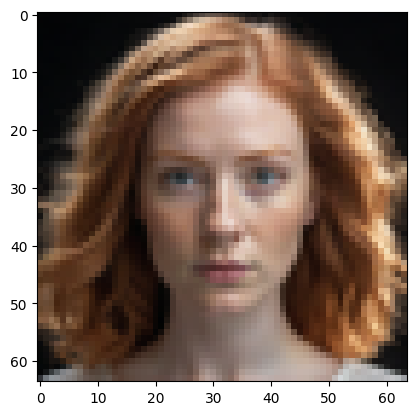

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.6067283..3.3236332].


Predict noise :


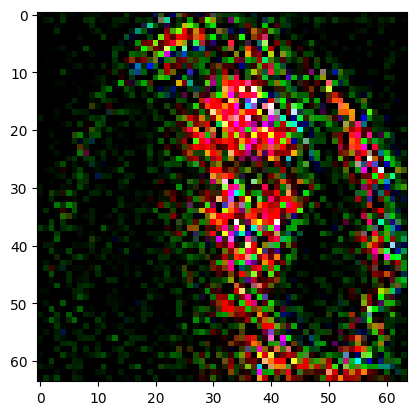

Training model:  10%|█         | 32/320 [01:24<12:44,  2.65s/it]


KeyboardInterrupt: 

In [ ]:
def train_denoiser(model:UNet, train_dataset:list[torch.Tensor], test_dataset:list[torch.Tensor]) -> TrainResult:

    sample_to_print = min(nb_sample_to_print, batch_size)
    test_dataset_tensor:torch.Tensor = torch.stack(test_dataset).cpu()
    train_dataset_tensor:torch.Tensor = torch.stack(train_dataset).cpu()

    optimizer:torch.optim.Adam = torch.optim.Adam(model.parameters(), lr = lr)#,  weight_decay=1e-5) #weight_decay for L2 regularization
    criterion:nn.MSELoss = nn.MSELoss()
    diffusion:DiffusionModel = DiffusionModel(model, optimizer, criterion, timestep, device)

    train_losses:list[float] = list[float]()
    test_losses:list[float] = list[float]()

    print("Start training UNet")
    with tqdm.tqdm(total=epochs * len(train_dataset), desc="Training model") as pbar:
        for epoch in range(0, epochs):

            print_sample = print_epoch_interval > 0 and ((epoch + 1) % print_epoch_interval == 0 or epoch + 1 == epochs)
            train_loader:DataLoader = DataLoader(train_dataset_tensor, batch_size, shuffle=True)
            input_batch:torch.Tensor = None
            total_loss:float = 0.0
            for input_batch in train_loader:
                
                loss, output_batch = diffusion.train_step(input_batch)
                total_loss += loss

                if print_sample:
                    print_sample = False
                    for i in range(0, sample_to_print):
                        noisy_img:torch.Tensor = input_batch[i].detach().cpu()
                        pred_noise:torch.Tensor = output_batch[i].detach().cpu()
                        print("Noisy image :")
                        plt.imshow(noisy_img.permute(1, 2, 0))
                        plt.show()
                        print("Predict noise :")
                        plt.imshow(pred_noise.permute(1, 2, 0))
                        plt.show()
                
                pbar.update(input_batch.shape[0])


            train_loss:float = total_loss / batch_size
            train_losses.append(train_loss)
            
            total_loss = 0.0
            train_loader:DataLoader = DataLoader(test_dataset_tensor, batch_size, shuffle=True)
            for input_batch in train_loader:
                loss, output_batch = diffusion.train_step(input_batch, False)
                total_loss += loss
            test_losses.append(total_loss / batch_size)

            print(f"Epoch {epoch+1}, Loss: {train_loss}")

    if saving_model:
        path = "./Models/denoiser.model"
        if os.path.isfile(path):
            os.remove(path)

        torch.save(model.state_dict(), path)
        print(f"Denoiser Saved!")

    return TrainResult(model, train_losses, test_losses)

train_dataset:list[torch.Tensor] = None
test_dataset:list[torch.Tensor] = None
train_dataset, test_dataset = train_test_split(dataset, test_size = test_proportion, random_state=42, shuffle=True)

denoiser:UNet = UNet(3, 64, time_embedding_dim, device)
train_result:TrainResult = train_denoiser(denoiser, train_dataset, test_dataset)
denoiser = train_result.denoiser

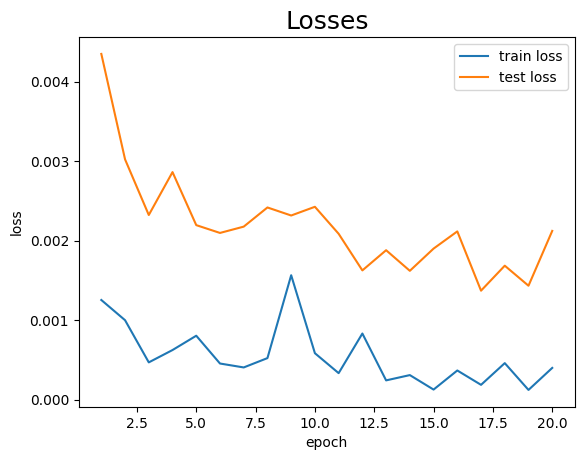

In [ ]:
def show_training_result(train_result:TrainResult) -> None:
    X:list[float] = [float(i) for i in range(1, epochs + 1)]
    plt.plot(X, train_result.train_losses, label='train loss')
    plt.plot(X, train_result.test_losses, label='test loss')
    plt.title("Losses", fontsize=18)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

show_training_result(train_result)

In [ ]:
def load_denoiser() -> Denoiser:
    model:Denoiser = Denoiser()
    model_path:str = os.path.join(os.getcwd(), "Models", "denoiser.model")
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    return model

denoiser = load_denoiser()

param_size = 0
for param in denoiser.parameters():
    param_size += param.nelement() * param.element_size()

size_all_mb = (param_size + 0) / 1024**2
print("Model size: {:.3f}MB with {} parameters".format(size_all_mb, sum(p.numel() for p in denoiser.parameters())))

Model size: 82.996MB with 21756995 parameters


In [ ]:
class GenerationParam:
    denoise_step:int
    preview_interval:int
    device:str

    def __init__(self, denoise_step:int, preview_interval:int, device:str) -> None:
        self.denoise_step = denoise_step
        self.preview_interval = preview_interval
        self.device = device

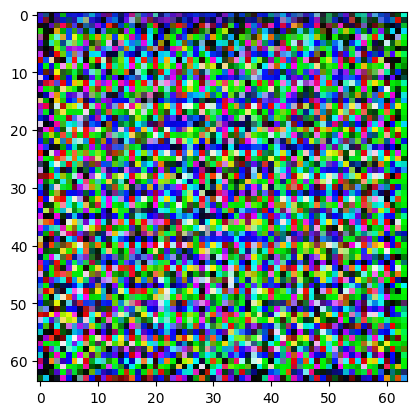

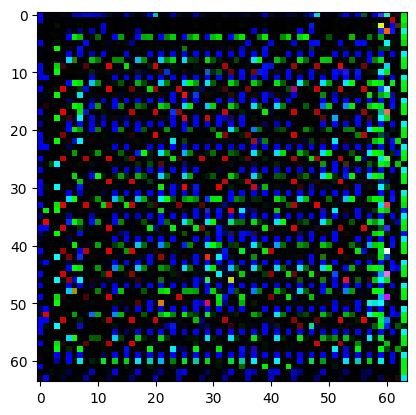

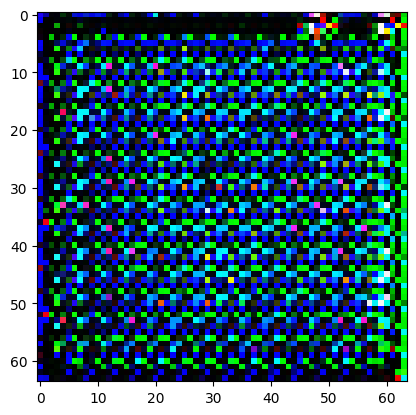

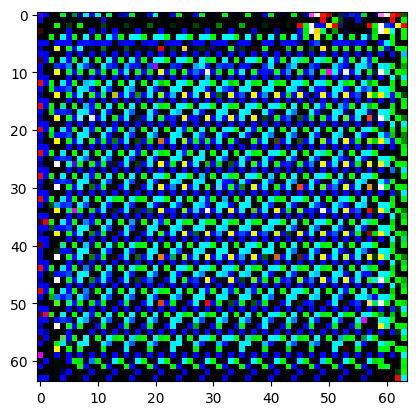

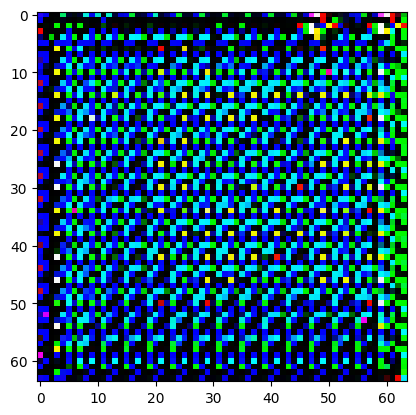

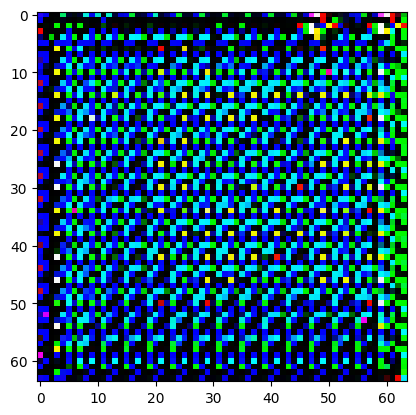

In [ ]:
def generate_face(denoiser:Denoiser, param:GenerationParam) -> torch.Tensor:
    denoiser = denoiser.to(device)
    # img:torch.Tensor = torch.rand(1, 3, 64, 64).to(device)
    size:tuple[int] = (1, 3, 64, 64)
    img:torch.Tensor = torch.clamp(torch.normal(torch.ones(size) * 0.5, torch.ones(size) * 0.125), torch.zeros(size), torch.ones(size))
    for i in range(param.denoise_step):
        img = denoiser(img)
        if param.preview_interval > 0 and ((i + 1) % param.preview_interval == 0 or i ==0):
            plot_img:torch.Tensor = img.cpu()[0]
            plot_img = plot_img.detach().permute(1, 2, 0)
            plt.imshow(plot_img)
            plt.show()

    return img[0].detach()

params = GenerationParam(50, 10, device)
image:torch.Tensor = generate_face(denoiser, params)
plt.imshow(image.cpu().permute(1, 2, 0))
plt.show()

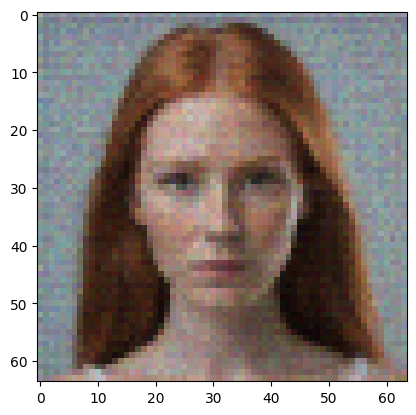

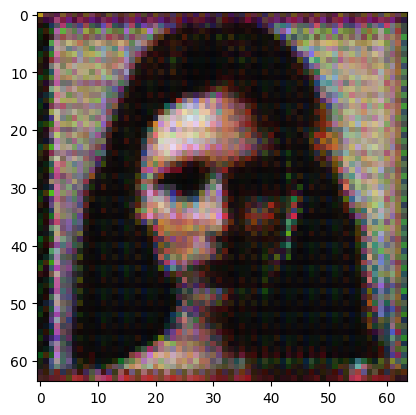

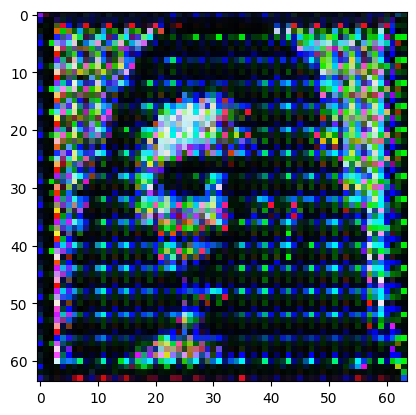

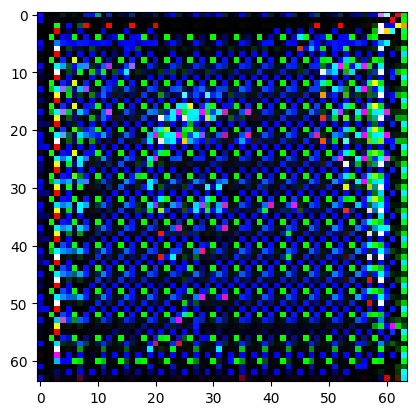

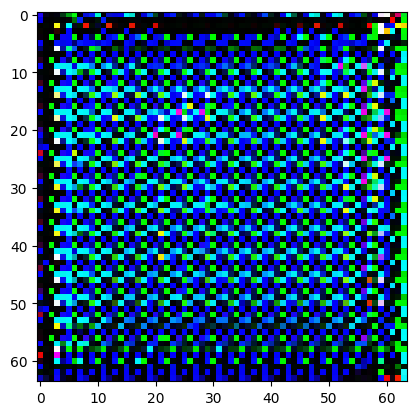

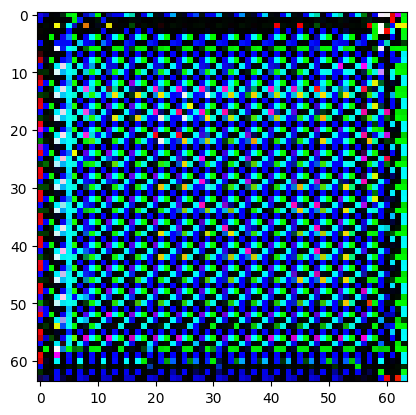

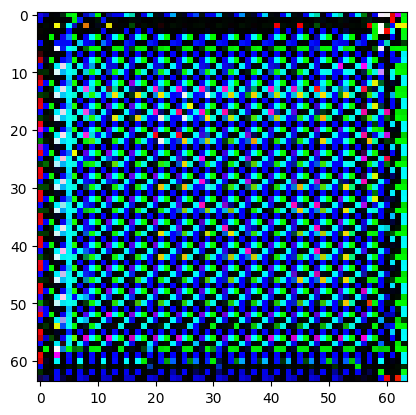

In [ ]:
def generate_face_bias(denoiser:Denoiser, param:GenerationParam, noice_level:float) -> torch.Tensor:
    denoiser = denoiser.to(device)
    start_image:torch.Tensor = dataset[random.randint(0, len(dataset) - 1)]
    # noise:torch.Tensor = torch.rand(start_image.shape)
    noise:torch.Tensor = torch.clamp(torch.normal(torch.ones(start_image.shape) * 0.5, torch.ones(start_image.shape) * 0.125), torch.zeros(start_image.shape), torch.ones(start_image.shape))

    start_image = (start_image * (1.0 - noice_level)) + (noise * noice_level)
    img:torch.Tensor = start_image.unsqueeze(0).to(device)
    for i in range(param.denoise_step):
        img = denoiser(img)
        if param.preview_interval > 0 and ((i + 1) % param.preview_interval == 0 or i == 0):
            plot_img:torch.Tensor = img.detach().cpu()[0].clone()
            plot_img = plot_img.permute(1, 2, 0)
            plt.imshow(plot_img)
            plt.show()

    return img[0].detach()

params = GenerationParam(50, 10, device)
image:torch.Tensor = generate_face_bias(denoiser, params, 0.1)
plt.imshow(image.cpu().permute(1, 2, 0))
plt.show()